In [1]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange

/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, namedtuple, defaultdict, Sequence
/Users/lucy/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module 

In [9]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)
    
### New AVR
def f_Lz(Lz):
    alpha=0.58
    lzsun=232.
    lumbda=1130.
    return (alpha*np.power(Lz/lzsun,2.)+np.exp(-(Lz-lzsun)/lumbda))/1+alpha

def f_feh(FeH):
    gamma=-0.52
    return 1.+gamma*FeH

def f_z(z):
    gamma=0.2
    return 1.+gamma*abs(z)

def f_tao(vd,Lz,FeH,z):
    sigma=21.1
    return vd/sigma/f_z(z)/f_feh(FeH)/f_Lz(Lz)

def get_age(vd,Lz,FeH,z):
    beta=0.441
    return np.power(f_tao(vd,Lz,FeH,z),1./beta)*10.1-0.1

In [77]:
df=pd.read_pickle('minchisq.pkl')
df_rvar=pd.read_pickle('minchisq_rvar.pkl')
print(np.shape(df))
df=df.dropna(subset=['Prot','teff_calc','abs_G','Prot_err','teff_val_err','abs_G_err','vel_dis']).reset_index(drop=True)
print(np.shape(df))

(23158, 79)
(23158, 79)


In [93]:
p_mp, p_mr, p_a=get_avr_coefficients()
age_old=v_to_age(df_rvar['vel_dis'], p_mr)
df_rvar['Lz_est']=df_rvar['R']*df_rvar['v_t']
age_new=get_age(df_rvar['vel_dis'],df_rvar['Lz_est'],np.ones(len(df_rvar))*-0.05,df_rvar['z'])
df_rvar['kin_age_Sharma2020']=age_new


/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [94]:
ASstars=pd.read_table('/Users/lucy/Desktop/KeplerAges/ASage.webarchive',delimiter=',',skiprows=2)
ASstars=ASstars.dropna(subset=['KIC'])

seismicKID=[12069424,12069449,3427720,3656476,5184732,6116048,6196457,6521045,7680114,7871531,8006161,8349582,
           9098294,9139151,9955598,10454113,10586004,10644253,10963065,11244118,11401755]

seismicAge=[7.07,6.82,2.23,8.13,4.17,6.23,5.51,6.24,7.19,9.15,5.04,7.93,7.28,1.71,6.43,2.03,6.35,
            1.07,4.36,6.43,5.85]
seismicAge_err=[0.46,0.28,0.17,0.59,0.40,0.37,0.71,0.37,0.70,0.47,0.17,0.94,0.51,0.19,0.47,0.29,
                1.37,0.25,0.46,0.58,0.93]

for i in ASstars['KIC'].unique():
    AS_single=ASstars.loc[ASstars['KIC']==i]
    seismicKID.append(int(i))
    seismicAge.append(np.mean(AS_single['Age']))
    seismicAge_err.append((max(AS_single['Age'])-min(AS_single['Age']))/2.)

    
All_ASstars=pd.DataFrame(np.array((seismicKID,seismicAge,seismicAge_err)).T,
                         columns=['KID','ASAge','ASAge_err'])

Clusters_cm=pd.merge(All_ASstars,df_rvar,left_on='KID',right_on='KIC',how='inner')
Clusters_cm





,KID_x,ASAge,ASAge_err,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,...,kepid_y,X,Y,z,R,parallax,kepid,v_t,Lz_est,kin_age_Sharma2020
0,3427720.0,2.230000,0.17000,3427720,1.060,0.067,-0.071,6037.9,112.6,-108.6,...,3427720.0,0.031995,-0.085005,0.022508,8.168448,10.657862,3427720.0,41.507948,339.055500,0.441512
1,3427720.0,2.330517,0.10935,3427720,1.060,0.067,-0.071,6037.9,112.6,-108.6,...,3427720.0,0.031995,-0.085005,0.022508,8.168448,10.657862,3427720.0,41.507948,339.055500,0.441512
2,7871531.0,9.150000,0.47000,7871531,0.815,0.039,-0.028,5386.2,86.4,-78.4,...,7871531.0,0.018167,-0.060415,0.020868,8.182056,15.028802,7871531.0,11.463795,93.797417,2.968997
3,7871531.0,9.360683,0.63170,7871531,0.815,0.039,-0.028,5386.2,86.4,-78.4,...,7871531.0,0.018167,-0.060415,0.020868,8.182056,15.028802,7871531.0,11.463795,93.797417,2.968997
4,8006161.0,5.040000,0.17000,8006161,0.959,0.048,-0.056,5342.0,81.0,-84.9,...,8006161.0,0.007443,-0.024348,0.009052,8.192593,36.978343,8006161.0,13.543470,110.956146,1.593768
5,8006161.0,4.653233,0.75495,8006161,0.959,0.048,-0.056,5342.0,81.0,-84.9,...,8006161.0,0.007443,-0.024348,0.009052,8.192593,36.978343,8006161.0,13.543470,110.956146,1.593768
6,9139151.0,1.710000,0.19000,9139151,1.149,0.047,-0.064,6122.0,105.0,-102.4,...,9139151.0,0.024558,-0.094451,0.032041,8.175988,9.706618,9139151.0,30.825027,252.025045,1.013073
7,9139151.0,1.859100,0.55440,9139151,1.149,0.047,-0.064,6122.0,105.0,-102.4,...,9139151.0,0.024558,-0.094451,0.032041,8.175988,9.706618,9139151.0,30.825027,252.025045,1.013073
8,9955598.0,6.430000,0.47000,9955598,0.912,0.051,-0.058,5375.2,88.8,-89.8,...,9955598.0,0.012200,-0.065399,0.014891,8.188061,14.639630,9955598.0,2.463125,20.168218,1.576009
9,9955598.0,6.680900,0.40405,9955598,0.912,0.051,-0.058,5375.2,88.8,-89.8,...,9955598.0,0.012200,-0.065399,0.014891,8.188061,14.639630,9955598.0,2.463125,20.168218,1.576009


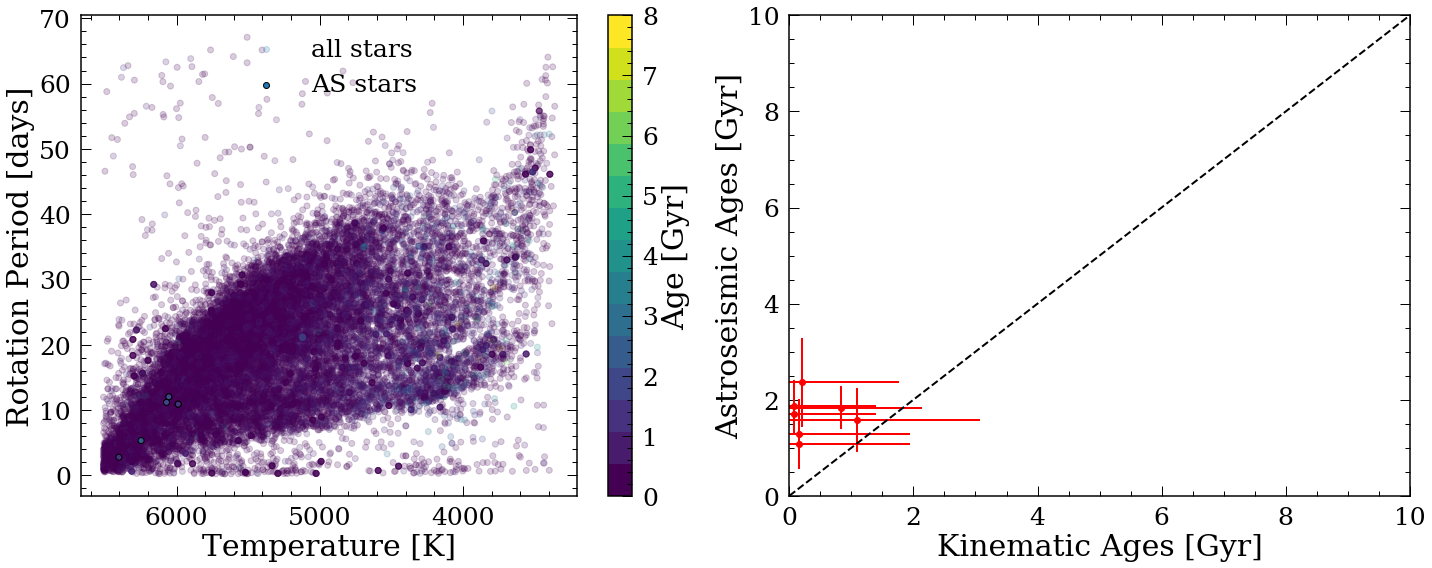

In [74]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(df['teff_calc'],df['Prot'],
            c=df['kin_age_Sharma2020'],cmap=cm,vmin=0,vmax=8,alpha=0.2,label='all stars')
plt.scatter(Clusters_cm['teff_calc'],Clusters_cm['Prot'],
            c=Clusters_cm['ASAge'],cmap=cm,vmin=0,vmax=8,edgecolor='k',label='AS stars')
cb=plt.colorbar()
plt.legend()

cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Rotation Period [days]')



plt.subplot(1,2,2)
plt.plot([0,10],[0,10],'k--')
plt.errorbar(Clusters_cm['kin_age_Sharma2020'],Clusters_cm['ASAge'],xerr=Clusters_cm['kin_age_err_bs'],
             yerr=Clusters_cm['ASAge_err'],fmt='ro')
    
plt.ylabel('Astroseismic Ages [Gyr]')
plt.xlabel('Kinematic Ages [Gyr]')
plt.xlim([0,10])
plt.ylim([0,10])
plt.tight_layout()

#plt.savefig('ASstars.png')

Text(0.5, 1.0, 'Average Ages')

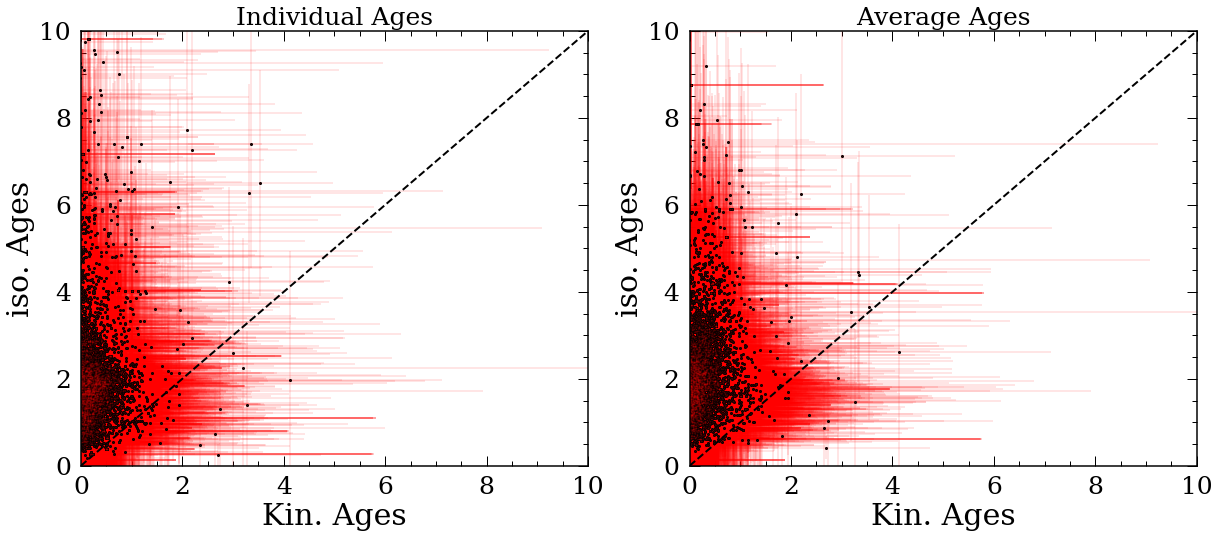

In [76]:
df['iso_age_err']=np.sqrt(df['iso_age_err1']**2+df['iso_age_err2']**2)

df_bin_plot=df.loc[df['iso_age']<10]
df_bin_plot=df_bin_plot.loc[df_bin_plot['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_bin_plot['kin_age_Sharma2020'], df_bin_plot['iso_age'],
             yerr=df_bin_plot['iso_age_err1'],xerr=df_bin_plot['kin_age_err_bs'],
             fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_bin_plot['kin_age_Sharma2020'], df_bin_plot['iso_age'],'ko',alpha=1,markersize=2)

plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.title('Individual Ages',fontsize=25)

plt.subplot(1,2,2)
plt.errorbar(df_bin_plot['kin_age_Sharma2020'], df_bin_plot['iso_age_ave'],
             yerr=df_bin_plot['iso_age_err1'],xerr=df_bin_plot['kin_age_err_bs'],
             fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_bin_plot['kin_age_Sharma2020'], df_bin_plot['iso_age_ave'],'ko',alpha=1,markersize=2)

plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.title('Average Ages',fontsize=25)
#plt.savefig('Iso_kin_ages.png')



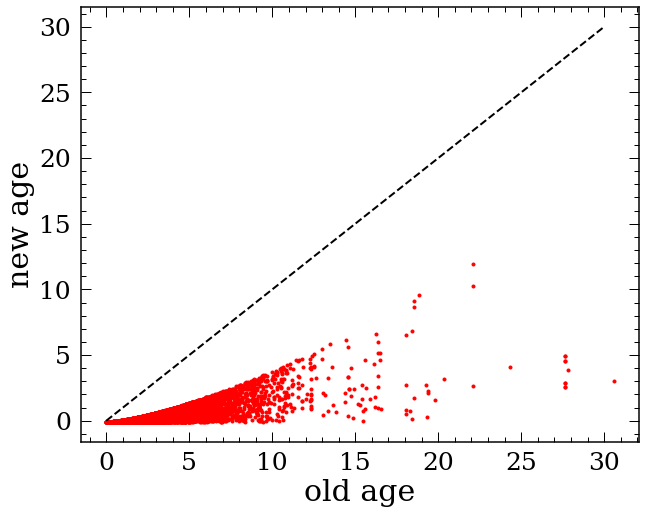

In [75]:
plt.figure(figsize=(10,8))
plt.plot(age_old,age_new,'r.')
plt.xlabel('old age')
plt.ylabel('new age')
plt.plot([0,30],[0,30],'k--')

## For Rvar

In [95]:
Clusters_cm_rvar=pd.merge(All_ASstars,df_rvar,left_on='KID',right_on='KID',how='inner')
Clusters_cm_rvar




,KID,ASAge,ASAge_err,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,...,kepid_y,X,Y,z,R,parallax,kepid,v_t,Lz_est,kin_age_Sharma2020
0,3427720.0,2.230000,0.17000,3427720,1.060,0.067,-0.071,6037.9,112.6,-108.6,...,3427720.0,0.031995,-0.085005,0.022508,8.168448,10.657862,3427720.0,41.507948,339.055500,0.441512
1,3427720.0,2.330517,0.10935,3427720,1.060,0.067,-0.071,6037.9,112.6,-108.6,...,3427720.0,0.031995,-0.085005,0.022508,8.168448,10.657862,3427720.0,41.507948,339.055500,0.441512
2,7871531.0,9.150000,0.47000,7871531,0.815,0.039,-0.028,5386.2,86.4,-78.4,...,7871531.0,0.018167,-0.060415,0.020868,8.182056,15.028802,7871531.0,11.463795,93.797417,2.968997
3,7871531.0,9.360683,0.63170,7871531,0.815,0.039,-0.028,5386.2,86.4,-78.4,...,7871531.0,0.018167,-0.060415,0.020868,8.182056,15.028802,7871531.0,11.463795,93.797417,2.968997
4,8006161.0,5.040000,0.17000,8006161,0.959,0.048,-0.056,5342.0,81.0,-84.9,...,8006161.0,0.007443,-0.024348,0.009052,8.192593,36.978343,8006161.0,13.543470,110.956146,1.593768
5,8006161.0,4.653233,0.75495,8006161,0.959,0.048,-0.056,5342.0,81.0,-84.9,...,8006161.0,0.007443,-0.024348,0.009052,8.192593,36.978343,8006161.0,13.543470,110.956146,1.593768
6,9139151.0,1.710000,0.19000,9139151,1.149,0.047,-0.064,6122.0,105.0,-102.4,...,9139151.0,0.024558,-0.094451,0.032041,8.175988,9.706618,9139151.0,30.825027,252.025045,1.013073
7,9139151.0,1.859100,0.55440,9139151,1.149,0.047,-0.064,6122.0,105.0,-102.4,...,9139151.0,0.024558,-0.094451,0.032041,8.175988,9.706618,9139151.0,30.825027,252.025045,1.013073
8,9955598.0,6.430000,0.47000,9955598,0.912,0.051,-0.058,5375.2,88.8,-89.8,...,9955598.0,0.012200,-0.065399,0.014891,8.188061,14.639630,9955598.0,2.463125,20.168218,1.576009
9,9955598.0,6.680900,0.40405,9955598,0.912,0.051,-0.058,5375.2,88.8,-89.8,...,9955598.0,0.012200,-0.065399,0.014891,8.188061,14.639630,9955598.0,2.463125,20.168218,1.576009


Text(0.5, 1.0, 'Average Ages')

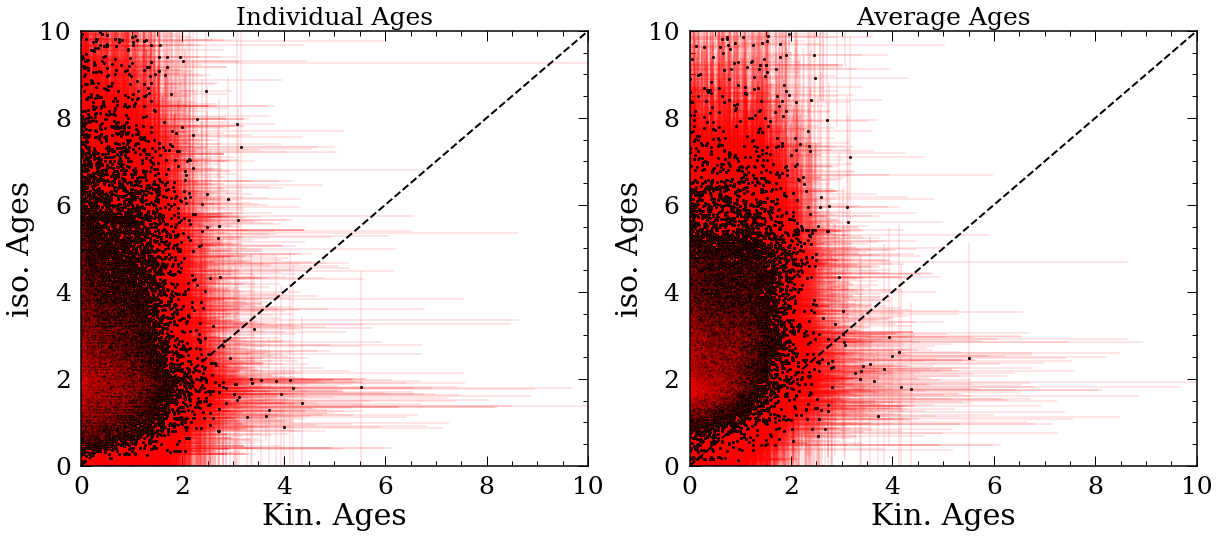

In [100]:
df_rvar['iso_age_err']=np.sqrt(df_rvar['iso_age_err1']**2+df_rvar['iso_age_err2']**2)

df_bin_plot_rvar=df_rvar.loc[df_rvar['iso_age']<10]
df_bin_plot_rvar=df_bin_plot_rvar.loc[df_bin_plot_rvar['iso_age_err1']<3]

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.errorbar(df_bin_plot_rvar['kin_age_Sharma2020'], df_bin_plot_rvar['iso_age'],
             yerr=df_bin_plot_rvar['iso_age_err1'],xerr=df_bin_plot_rvar['kin_age_err'],
             fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_bin_plot_rvar['kin_age_Sharma2020'], df_bin_plot_rvar['iso_age'],'ko',alpha=1,markersize=2)

plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.title('Individual Ages',fontsize=25)

plt.subplot(1,2,2)
plt.errorbar(df_bin_plot_rvar['kin_age_Sharma2020'], df_bin_plot_rvar['iso_age_ave'],
             yerr=df_bin_plot_rvar['iso_age_err1'],xerr=df_bin_plot_rvar['kin_age_err'],
             fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_bin_plot_rvar['kin_age_Sharma2020'], df_bin_plot_rvar['iso_age_ave'],'ko',alpha=1,markersize=2)

plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.title('Average Ages',fontsize=25)
#plt.savefig('Iso_kin_ages_rvar.png')




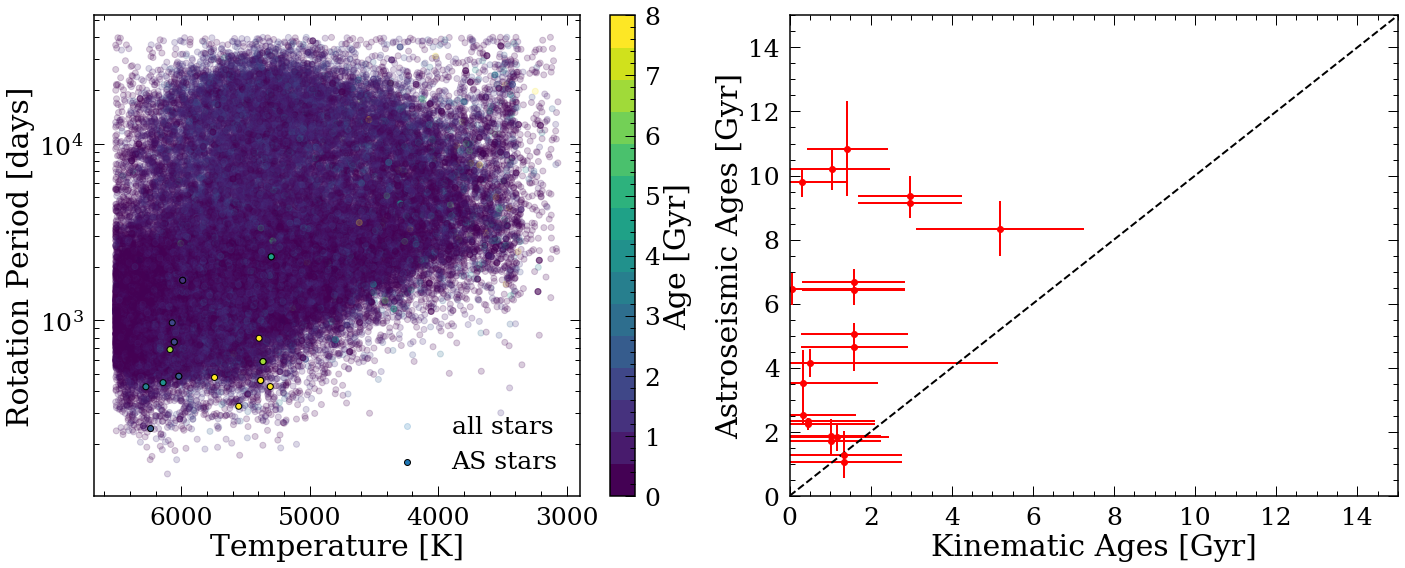

In [97]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(df_rvar['teff_calc'],df_rvar['Rvar'],
            c=df_rvar['kin_age_Sharma2020'],cmap=cm,vmin=0,vmax=8,alpha=0.2,label='all stars')
plt.scatter(Clusters_cm_rvar['teff_calc'],Clusters_cm_rvar['Rvar'],
            c=Clusters_cm_rvar['ASAge'],cmap=cm,vmin=0,vmax=8,edgecolor='k',label='AS stars')
cb=plt.colorbar()
plt.legend()

cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('Rotation Period [days]')



plt.subplot(1,2,2)
plt.plot([0,15],[0,15],'k--')
plt.errorbar(Clusters_cm_rvar['kin_age_Sharma2020'],Clusters_cm_rvar['ASAge'],xerr=Clusters_cm_rvar['kin_age_err_bs'],
             yerr=Clusters_cm_rvar['ASAge_err'],fmt='ro')

plt.ylabel('Astroseismic Ages [Gyr]')
plt.xlabel('Kinematic Ages [Gyr]')
plt.xlim([0,15])
plt.ylim([0,15])
plt.tight_layout()

#plt.savefig('ASstars_rvar.png')

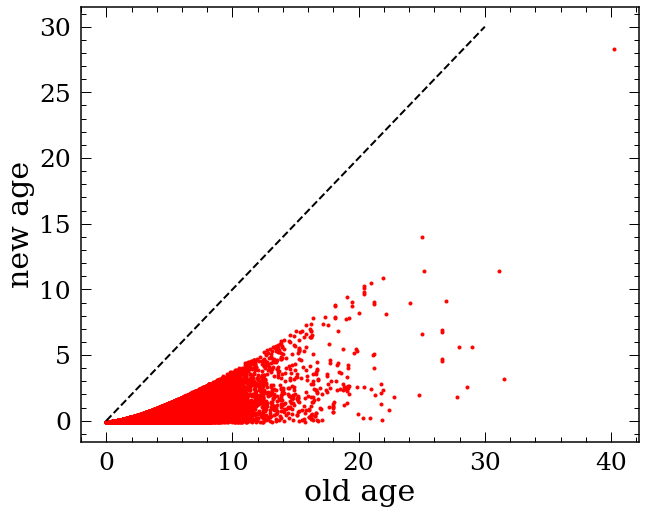

In [98]:
plt.figure(figsize=(10,8))
plt.plot(age_old,age_new,'r.')
plt.xlabel('old age')
plt.ylabel('new age')
plt.plot([0,30],[0,30],'k--')

# Add new columns

In [20]:
with fits.open('/Users/lucy/Desktop/FirstYearML/kepler_dr2_1arcsec.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")

In [89]:
df_rvar=pd.merge(df_rvar,gaia[['parallax','kepid']],
                 left_on='KIC',right_on='kepid',how='inner')

In [81]:
df_rvar=df_rvar.drop_duplicates('KIC',keep='first')

In [102]:
df_rvar.to_pickle('minchisq_rvar.pkl')

In [85]:
df_rvar

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,designation,pmra,pmdec,l,b,ra,dec,kepid_x,r_est,kepid_y
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,Gaia DR2 2050231848829944320,7.989605,-2.449177,69.199949,9.719302,291.137620,36.577344,757450.0,835.356174,757450.0
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,Gaia DR2 2050232364226074624,-4.309371,-10.804409,69.265698,9.748225,291.141664,36.648235,892718.0,869.137627,892718.0
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,Gaia DR2 2050235731480463616,-13.636020,-1.677404,69.297656,9.753616,291.153283,36.678799,892772.0,656.786528,892772.0
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,Gaia DR2 2050232776542967680,-16.438887,-17.319701,69.297053,9.744538,291.163064,36.674193,892832.0,789.364534,892832.0
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,Gaia DR2 2050232089348169856,3.094388,5.367764,69.254876,9.723454,291.163281,36.627582,892834.0,566.430305,892834.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85487,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,Gaia DR2 2139325653978247808,4.204155,24.466874,83.628962,16.928007,290.233000,52.336099,12935144.0,700.202757,12935144.0
85488,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,Gaia DR2 2139336408576560512,0.101958,-4.184583,83.620610,17.130331,289.921973,52.406373,12983952.0,1224.606969,12983952.0
85489,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,Gaia DR2 2139336099338925312,-4.768883,-9.874269,83.648255,17.113365,289.964228,52.424308,12984012.0,1432.376297,12984012.0
85490,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,Gaia DR2 2139341768695774336,-0.247939,-0.834232,83.680270,17.080006,290.033980,52.439817,12984138.0,925.003474,12984138.0


In [86]:
def convd2R(rad):
    return rad/180*np.pi
df_rvar['X'] = df_rvar.r_est * np.cos(convd2R(df_rvar.b)) * np.cos(convd2R(df_rvar.l)) / 1000.
df_rvar['Y'] = -df_rvar.r_est * np.sin(convd2R(df_rvar.l)) * np.cos(convd2R(df_rvar.b))/ 1000.
df_rvar['z'] = df_rvar.r_est * np.sin(convd2R(df_rvar.b))/ 1000.
df_rvar['R'] = np.sqrt(np.power(df_rvar.X - 8.2,2.) + np.power(df_rvar.Y,2.))


In [90]:
df_rvar['v_t'],df_rvar['v_b']=Astraea.getVs(df_rvar)

/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/units/equivalencies.py:90: RuntimeWarning: invalid value encountered in less
  d[d < 0] = np.nan
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:466: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/distances.py:183: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/lucy/anaconda3/lib/python3.7/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/lucy/anaconda3/lib/pytho

In [101]:
df_rvar

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,kepid_y,X,Y,z,R,parallax,kepid,v_t,Lz_est,kin_age_Sharma2020
0,757450,0.914,0.062,-0.057,5301.2,111.0,-103.1,4.432,0.045,-0.044,...,757450.0,0.292384,-0.769703,0.141026,7.944988,1.168913,757450.0,33.889670,269.253033,0.888474
1,892718,0.782,0.040,-0.046,5000.9,97.3,-90.3,4.570,0.028,-0.036,...,892718.0,0.303262,-0.801109,0.147161,7.937269,1.123321,892718.0,49.088081,389.625320,0.332151
2,892772,0.803,0.039,-0.032,4965.0,96.3,-93.6,4.492,0.040,-0.034,...,892772.0,0.228827,-0.605497,0.111267,7.994137,1.499367,892772.0,43.437266,347.243470,0.460172
3,892832,0.784,0.040,-0.045,4975.7,97.1,-88.2,4.564,0.028,-0.034,...,892832.0,0.275032,-0.727739,0.133604,7.958311,1.239068,892832.0,91.357351,727.050225,-0.038991
4,892834,0.751,0.034,-0.039,4823.2,90.4,-82.2,4.587,0.023,-0.028,...,892834.0,0.197754,-0.522096,0.095666,8.019260,1.737008,892834.0,16.909004,135.597695,0.445367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88409,12935144,0.781,0.032,-0.023,4798.5,80.8,-74.4,4.515,0.028,-0.020,...,12935144.0,0.074333,-0.665727,0.203878,8.152893,1.399630,12935144.0,84.082452,685.515233,-0.054381
88410,12983952,0.897,0.062,-0.046,5407.1,121.4,-103.9,4.188,0.037,-0.037,...,12983952.0,0.130032,-1.163034,0.360703,8.153345,0.787841,12983952.0,25.186284,205.352468,0.460145
88411,12984012,1.074,0.071,-0.078,6005.1,116.3,-113.9,4.337,0.046,-0.050,...,12984012.0,0.151450,-1.360554,0.421496,8.162736,0.669294,12984012.0,77.666784,633.973444,0.037189
88412,12984138,0.811,0.048,-0.039,5052.3,90.3,-82.6,4.501,0.041,-0.034,...,12984138.0,0.097330,-0.878833,0.271680,8.150190,1.052836,12984138.0,3.918576,31.937140,1.928145


0        -0.966857
1       -47.684635
2         4.320261
3       -19.842956
4         7.085213
           ...    
20993   -29.351048
20994     8.648168
20995   -46.627427
20996    -1.165221
20997    -0.407244
Name: v_b, Length: 20640, dtype: float64